# **Open University Learning Analytics(OULAD): User Rentention Survival Analysis and Conversion Analysis**
--- 
Students attended the Virtual Learning Environment (VLE) for seven modules. Their interactions with module materials and final outcomes were recorded. Presentations of courses start in February and October - they are marked by 'B' and 'J' respectively. 
link to the dataset: https://analyse.kmi.open.ac.uk/open-dataset#description

## **Aims** 
To explore the factors associated with the churn of users and the conversion of users to sucessfully complete the course, with adjustments of demographic factors. 

## **Database schema**

<p align="center">
  <img src="figures/database_schema.png" width="700">
</p>




## **Key metrics**
---
### **Primary Metrics**:
  - **Registration**: The number of users signed up for the module presentation. 
  - **Activation**: The number of users who signed up for the module presentation and has generated at least one interaction event within the first k days of the presentation (e.g., k = 7).
  - **Retention**: The number of users who has not withdrawn by time t since the start of the module presentation. 
  - **Churn**: The number of users who withdrew by time t since the start of the module presentation.
  - **Conversion**: The number of users who completed the module with a final result of 'Distinction' or 'Pass'. 
### **Secondary Metrics**:
  - **No. of attempts**: The number times a user has previously enrolled the same module (across presentations).
  - **Presentation type**: The type of presentation (i.e. 'J' for presentation starting in October and 'B' for presentation starting in February) 
  - **Interaction date**: Number of days since the start of the module presentation when an interaction with module material occurred.
  - **Daily click count**: Total number of interactions events generated by a user on a given day. 
  - **Final result**: Final outcome of the module presentation (i.e. 'Distinction','Pass', 'Fail' or 'Withdraw')
### **Demographic Covarites**: 
  - **Age**: Age band ('0-35','35-55','55+')
  - **Gender**
  - **Highest education**
  - **IMD**: Index of Multiple Deprivation
  - **Disability**: yes or no 
### **Module-related covariates**: 
  - **Module credits**: The total number of credits of the module the user is currently taking 
  - **length of module presentation**: length of the module-presentation in days
  - **Assessment type**: Three types of assessments: Tutor Marked Assessment (TMA), Computer Marked Assessment (CMA) and Final Exam (Exam)
  - **Assessment date**: Number of days since the start of the module presentation when the assessment is due.
  - **Assessment weight**: Percentage contribution of the assessment to the final module score.

## **Questions, Hypotheses & Analysis plan**
---
### **Questions**
1. Within the same module, do different presentations change the final outcome?
2. Do early activation significantly affect conversion?
3. Explore churner profile
    - What characteristics of churners are different from non-chuners? 
    - When do churners churn more frequently? 
4. Explore conversion profile 
    - What characteristics of converters are different from non-converters?
5. What factors predict retention over time? 
6. What factors predict final conversion? 
### **Hypotheses & Analysis plan**

  **1. Different module presentation term will affect retention and conversion (module completion) rate.** 
  - Descriptive statistics
    - retention & conversion rate by module presentation term & year  
  
  **2. Early activation will affect retention and conversion (module completion).**
  - Descriptive statistics
    - retention & conversion rate by early activation 

  **3. Churner profile will differ from non-churner profile.**
  - Descriptive statistics & plots 

  **4. Converted user profile will differ from non-converted user profile.**
  - Descriptive statistics & plots  

  **5. Conversion will differ across modules.**
  - Descriptive analysis: Chi-square test for distribution difference 
    - Chi-square test for presentation term x conversion 
    - Chi-square test for early activation x conversion
    - Chi-square test for module x conversion

  **6. Early activation will reduce churn (improve retention) with control of covariates.** 
  - Survival analysis 
    - Kaplan-Meier estimator for visualization of survival curves 
    - Log-rank test for testing difference between groups (presentation type: 'J' vs 'B'; early activation: 'Yes' vs 'No')
    - Cox Proportional Hazards (PH) Model with assumptions check
    - Weibull Accelerated Failure Time (AFT) Model 

  **7. Early activation will be positively associated with conversion, independently of other factors.**
  - Logistic regression 
    - ROC-AUC for model performance 



In [240]:
from IPython.display import Image, display
import pandas as pd 
import numpy as np
!pip install lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test 
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

## Loading data and data preprocessing 

In [193]:
# loading data 
user_reg = pd.read_csv('C:/Users/08042/Desktop/projects/OULAD/data/studentRegistration.csv')
user_info = pd.read_csv('C:/Users/08042/Desktop/projects/OULAD/data/studentInfo.csv')
user_vle = pd.read_csv('C:/Users/08042/Desktop/projects/OULAD/data/studentVle.csv')
user_assessment = pd.read_csv('C:/Users/08042/Desktop/projects/OULAD/data/studentAssessment.csv')
vle_desc = pd.read_csv('C:/Users/08042/Desktop/projects/OULAD/data/vle.csv')
courses = pd.read_csv('C:/Users/08042/Desktop/projects/OULAD/data/courses.csv')

In [194]:
user_reg.head()
user_info.head()
courses.head()
print(user_reg.columns)
print(user_info.columns)
print(courses.columns)

Index(['code_module', 'code_presentation', 'id_student', 'date_registration',
       'date_unregistration'],
      dtype='object')
Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result'],
      dtype='object')
Index(['code_module', 'code_presentation', 'module_presentation_length'], dtype='object')


In [195]:
# characters to ordinal/binary values 
edu_map={'No Formal quals':0, 
         'Lower Than A Level':1, 
         'A Level or Equivalent':2, 
         'HE Qualification':3, 
         'Post Graduate Qualification':4}
imd_map={'0-10%':0, 
         '10-20%':1, 
         '20-30%':2, 
         '30-40%':3, 
         '40-50%':4, 
         '50-60%':5, 
         '60-70%':6, 
         '70-80%':7, 
         '80-90%':8, 
         '90-100%':9}
age_map={'0-35':0,
         '35-55':1,
         '55<':2}


user_info['edu_ord']= user_info['highest_education'].map(edu_map)
user_info['imd_ord']= user_info['imd_band'].map(imd_map)    
user_info['age_ord']= user_info['age_band'].map(age_map)
user_info['Gender'] = user_info['gender'].map({'M':1,'F':0})
user_info['disability'] = user_info['disability'].map({'Y':1,'N':0})
user_info['converted'] = user_info['final_result'].isin(['Pass','Distinction']).astype(int)
user_info['churned'] = (user_info['final_result']=='Withdrawn').astype(int)
print(user_info[['edu_ord','imd_ord','age_ord']].isna().mean())
print(user_info['code_presentation'].value_counts())

user_info['imd_ord_missing'] = user_info['imd_ord'].isna().astype(int)
user_info['imd_ord_filled'] = user_info['imd_ord'].fillna(-1)

# Extract year and term
user_info['presentation_year'] = user_info['code_presentation'].str[:4].astype(int)
user_info['presentation_term'] = user_info['code_presentation'].str[-1]

# Binary encode term (J = 1, B = 0)
user_info['term_J'] = (user_info['presentation_term'] == 'J').astype(int)

user_info

edu_ord    0.000000
imd_ord    0.141963
age_ord    0.006627
dtype: float64
code_presentation
2014J    11260
2013J     8845
2014B     7804
2013B     4684
Name: count, dtype: int64


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,imd_ord,age_ord,Gender,converted,churned,imd_ord_missing,imd_ord_filled,presentation_year,presentation_term,term_J
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,9.0,NaN,1,1,0,0,9.0,2013,J,1
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,2.0,1.0,0,1,0,0,2.0,2013,J,1
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,...,3.0,1.0,0,0,1,0,3.0,2013,J,1
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,5.0,1.0,0,1,0,0,5.0,2013,J,1
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,5.0,0.0,0,1,0,0,5.0,2013,J,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,...,NaN,0.0,0,0,0,1,-1.0,2014,J,1
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,...,4.0,1.0,0,1,0,0,4.0,2014,J,1
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,...,2.0,0.0,0,1,0,0,2.0,2014,J,1
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,...,9.0,1.0,0,0,1,0,9.0,2014,J,1


### Creating churn-related features 

In [196]:
# merging data 
user_module_pre = (user_info
                   .merge(
                       user_reg, 
                       on=['code_module', 'code_presentation', 'id_student'], how='left')
                    .merge(
                        courses,
                        on=['code_module', 'code_presentation'], how='left'))

# defining time-to-churn and event_churn
user_module_pre['date_unregistration_filled'] = (
    user_module_pre['date_unregistration'].
    fillna(user_module_pre['module_presentation_length'])
)
user_module_pre['time_to_churn'] = np.where(
    user_module_pre['churned'] == 1,
    # to ensure time_to_churn does not exceed module length
    np.minimum(user_module_pre['date_unregistration_filled'],user_module_pre['module_presentation_length']),
    user_module_pre['module_presentation_length']
)
# exclude pre-start churners
user_module_pre_surv = user_module_pre[
    ~((user_module_pre['churned']==1) & 
    (user_module_pre['date_unregistration']<0))
].copy()

user_module_pre_surv['event_churn']= user_module_pre_surv['churned']

user_module_pre__surv_cols = [
    'id_student', 'code_module', 'code_presentation',
    'presentation_year', 'term_J',
    'converted', 'churned',
    'time_to_churn', 'event_churn',
    'date_registration', 'module_presentation_length',
    'edu_ord', 'imd_ord_filled', 'imd_ord_missing',
    'age_ord', 'Gender', 'disability',
    'num_of_prev_attempts', 'studied_credits'
]

user_module_pre_surv = user_module_pre_surv[user_module_pre__surv_cols]
user_module_pre_surv

,id_student,code_module,code_presentation,presentation_year,term_J,converted,churned,time_to_churn,event_churn,date_registration,module_presentation_length,edu_ord,imd_ord_filled,imd_ord_missing,age_ord,Gender,disability,num_of_prev_attempts,studied_credits
0,11391,AAA,2013J,2013,1,1,0,268.0,0,-159.0,268,3,9.0,0,NaN,1,0,0,240
1,28400,AAA,2013J,2013,1,1,0,268.0,0,-53.0,268,3,2.0,0,1.0,0,0,0,60
2,30268,AAA,2013J,2013,1,0,1,12.0,1,-92.0,268,2,3.0,0,1.0,0,1,0,60
3,31604,AAA,2013J,2013,1,1,0,268.0,0,-52.0,268,2,5.0,0,1.0,0,0,0,60
4,32885,AAA,2013J,2013,1,1,0,268.0,0,-176.0,268,1,5.0,0,0.0,0,0,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,2640965,GGG,2014J,2014,1,0,0,269.0,0,-4.0,269,1,-1.0,1,0.0,0,0,0,30
32589,2645731,GGG,2014J,2014,1,1,0,269.0,0,-23.0,269,1,4.0,0,1.0,0,0,0,30
32590,2648187,GGG,2014J,2014,1,1,0,269.0,0,-129.0,269,2,2.0,0,0.0,0,1,0,30
32591,2679821,GGG,2014J,2014,1,0,1,101.0,1,-49.0,269,1,9.0,0,1.0,0,0,0,30


### Create early activation features 

In [197]:
vle_pre = user_vle[user_vle['date']<0].copy()
vle_post = user_vle[user_vle['date']>=0].copy()
vle_pre.head()
vle_post.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
10847,AAA,2013J,345357,546667,0,3
10848,AAA,2013J,345357,546883,0,1
10849,AAA,2013J,345357,546732,0,14
10850,AAA,2013J,345357,546614,0,5
10851,AAA,2013J,345357,546876,0,1


In [198]:
prestart=(
    vle_pre
    .groupby(['id_student', 'code_module', 'code_presentation'])
    .agg(
        prestart_clicks = ('sum_click', 'sum'),
        prestart_active = ('sum_click', lambda x:int(x.sum()>0))
    )
    .reset_index()
)
prestart

,id_student,code_module,code_presentation,prestart_clicks,prestart_active
0,6516,AAA,2014J,256,1
1,8462,DDD,2013J,81,1
2,11391,AAA,2013J,98,1
3,23629,BBB,2013B,14,1
4,23698,CCC,2014J,181,1
...,...,...,...,...,...
23804,2698125,FFF,2013J,14,1
23805,2698251,DDD,2014B,174,1
23806,2698257,AAA,2013J,24,1
23807,2698535,CCC,2014B,28,1


In [199]:
# post-start early engagement 
early_window = 14 # days
vle_early = vle_post[
    (vle_post['date']>=0) & (vle_post['date']<early_window)
    ].copy()
vle_early

,code_module,code_presentation,id_student,id_site,date,sum_click
10847,AAA,2013J,345357,546667,0,3
10848,AAA,2013J,345357,546883,0,1
10849,AAA,2013J,345357,546732,0,14
10850,AAA,2013J,345357,546614,0,5
10851,AAA,2013J,345357,546876,0,1
...,...,...,...,...,...,...
10557848,GGG,2014J,2282141,897051,13,1
10557849,GGG,2014J,2282141,896943,13,2
10557850,GGG,2014J,2270562,896943,13,2
10557851,GGG,2014J,2270562,896980,13,7


In [200]:
# post-start early engagement features
early_features = (
    vle_early
    .groupby(['id_student', 'code_module', 'code_presentation'])
    .agg(
        early_clicks_14 = ('sum_click', 'sum'),
        early_active_days_14 = ('date', lambda x:x.nunique()),
        early_activated_14 = ('sum_click', lambda x:int(x.sum()>0)),
        first_interaction_day_0plus = ('date', lambda x:x.min()),
    )
    .reset_index()
)
early_features 

,id_student,code_module,code_presentation,early_clicks_14,early_active_days_14,early_activated_14,first_interaction_day_0plus
0,6516,AAA,2014J,271,10,1,0
1,8462,DDD,2013J,227,9,1,0
2,8462,DDD,2014J,10,1,1,10
3,11391,AAA,2013J,203,5,1,0
4,23629,BBB,2013B,28,3,1,2
...,...,...,...,...,...,...,...
26420,2698251,DDD,2014B,147,7,1,2
26421,2698257,AAA,2013J,68,4,1,2
26422,2698535,CCC,2014B,367,8,1,1
26423,2698535,EEE,2013J,19,3,1,0


In [201]:
user_module_pre_surv = (
    user_module_pre_surv
    .merge(
        prestart,
        on=['id_student', 'code_module', 'code_presentation'],
        how='left'
    )
    .merge(
        early_features,
        on=['id_student', 'code_module', 'code_presentation'],
        how='left'))

# fill 0 for no pre-start and early engagement
fill_0 =[
    'prestart_clicks', 'prestart_active',
    'early_clicks_14', 'early_active_days_14', 'early_activated_14'
]
for col in ['prestart_clicks', 'prestart_active']:
    if col not in user_module_pre_surv.columns:
        user_module_pre_surv[col] = 0

for col in fill_0: 
    user_module_pre_surv[col] = user_module_pre_surv[col].fillna(0)

user_module_pre_surv

,id_student,code_module,code_presentation,presentation_year,term_J,converted,churned,time_to_churn,event_churn,date_registration,...,Gender,disability,num_of_prev_attempts,studied_credits,prestart_clicks,prestart_active,early_clicks_14,early_active_days_14,early_activated_14,first_interaction_day_0plus
0,11391,AAA,2013J,2013,1,1,0,268.0,0,-159.0,...,1,0,0,240,98.0,1.0,203.0,5.0,1.0,0.0
1,28400,AAA,2013J,2013,1,1,0,268.0,0,-53.0,...,0,0,0,60,215.0,1.0,241.0,7.0,1.0,0.0
2,30268,AAA,2013J,2013,1,0,1,12.0,1,-92.0,...,0,1,0,60,102.0,1.0,179.0,6.0,1.0,4.0
3,31604,AAA,2013J,2013,1,1,0,268.0,0,-52.0,...,0,0,0,60,169.0,1.0,176.0,7.0,1.0,1.0
4,32885,AAA,2013J,2013,1,1,0,268.0,0,-176.0,...,0,0,0,60,295.0,1.0,177.0,9.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29912,2640965,GGG,2014J,2014,1,0,0,269.0,0,-4.0,...,0,0,0,30,2.0,1.0,17.0,2.0,1.0,0.0
29913,2645731,GGG,2014J,2014,1,1,0,269.0,0,-23.0,...,0,0,0,30,0.0,0.0,0.0,0.0,0.0,NaN
29914,2648187,GGG,2014J,2014,1,1,0,269.0,0,-129.0,...,0,1,0,30,15.0,1.0,9.0,1.0,1.0,5.0
29915,2679821,GGG,2014J,2014,1,0,1,101.0,1,-49.0,...,0,0,0,30,65.0,1.0,4.0,1.0,1.0,3.0


In [202]:
# fill inf for no interaction at all post start 
user_module_pre_surv['first_interaction_day_0plus']=(user_module_pre_surv['first_interaction_day_0plus'].fillna(np.inf))
user_module_pre_surv

,id_student,code_module,code_presentation,presentation_year,term_J,converted,churned,time_to_churn,event_churn,date_registration,...,Gender,disability,num_of_prev_attempts,studied_credits,prestart_clicks,prestart_active,early_clicks_14,early_active_days_14,early_activated_14,first_interaction_day_0plus
0,11391,AAA,2013J,2013,1,1,0,268.0,0,-159.0,...,1,0,0,240,98.0,1.0,203.0,5.0,1.0,0.0
1,28400,AAA,2013J,2013,1,1,0,268.0,0,-53.0,...,0,0,0,60,215.0,1.0,241.0,7.0,1.0,0.0
2,30268,AAA,2013J,2013,1,0,1,12.0,1,-92.0,...,0,1,0,60,102.0,1.0,179.0,6.0,1.0,4.0
3,31604,AAA,2013J,2013,1,1,0,268.0,0,-52.0,...,0,0,0,60,169.0,1.0,176.0,7.0,1.0,1.0
4,32885,AAA,2013J,2013,1,1,0,268.0,0,-176.0,...,0,0,0,60,295.0,1.0,177.0,9.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29912,2640965,GGG,2014J,2014,1,0,0,269.0,0,-4.0,...,0,0,0,30,2.0,1.0,17.0,2.0,1.0,0.0
29913,2645731,GGG,2014J,2014,1,1,0,269.0,0,-23.0,...,0,0,0,30,0.0,0.0,0.0,0.0,0.0,inf
29914,2648187,GGG,2014J,2014,1,1,0,269.0,0,-129.0,...,0,1,0,30,15.0,1.0,9.0,1.0,1.0,5.0
29915,2679821,GGG,2014J,2014,1,0,1,101.0,1,-49.0,...,0,0,0,30,65.0,1.0,4.0,1.0,1.0,3.0


In [203]:
# quick look 
user_module_pre_surv[[
    'early_clicks_14', 'early_activated_14', 'early_active_days_14','first_interaction_day_0plus','prestart_active'
]].describe()

,early_clicks_14,early_activated_14,early_active_days_14,first_interaction_day_0plus,prestart_active
count,29917.000000,29917.000000,29917.000000,29917.0,29917.000000
mean,127.171608,0.880102,4.928201,inf,0.781228
std,178.617661,0.324848,3.844065,NaN,0.413420
min,0.000000,0.000000,0.000000,0.0,0.000000
25%,16.000000,1.000000,2.000000,0.0,1.000000
50%,68.000000,1.000000,4.000000,2.0,1.000000
75%,170.000000,1.000000,8.000000,5.0,1.000000
max,4733.000000,1.000000,14.000000,inf,1.000000


### Descriptive statistics on churn, conversion and early activation

In [204]:
# quick EDA on churn and conversion rates 
print(user_module_pre_surv[['converted', 'churned']].mean())
print(user_module_pre_surv.groupby('term_J')[['converted', 'churned']].mean())
print(user_module_pre_surv.groupby('presentation_year')[['converted', 'churned']].mean())
print(user_module_pre_surv.groupby(['presentation_year','term_J'])[['converted', 'churned']].mean())
print(user_module_pre_surv.groupby('code_module')[['converted', 'churned']].mean())

converted    0.514256
churned      0.250025
dtype: float64
        converted   churned
term_J                     
0        0.478543  0.251689
1        0.536227  0.249001
                   converted   churned
presentation_year                     
2013                0.523214  0.218603
2014                0.507776  0.272753
                          converted   churned
presentation_year term_J                     
2013              0        0.476136  0.241818
                  1        0.548609  0.206081
2014              0        0.480057  0.257898
                  1        0.526483  0.282779
             converted   churned
code_module                     
AAA           0.729396  0.145604
BBB           0.532331  0.217102
CCC           0.422564  0.380761
DDD           0.453361  0.301372
EEE           0.599782  0.195929
FFF           0.507442  0.254556
GGG           0.613204  0.091940


In [205]:
# quick check of early activity vs conversion/churn
user_module_pre_surv.groupby('early_activated_14')[['converted', 'churned']].mean()

,converted,churned
early_activated_14,,
0.0,0.21327,0.446055
1.0,0.55526,0.223319


In [206]:
user_module_pre_surv[['time_to_churn','event_churn']].describe()
user_module_pre_surv['event_churn'].value_counts(normalize=True)
user_module_pre_surv[['time_to_churn','event_churn']].isna().sum()

time_to_churn    0
event_churn      0
dtype: int64

#### Chuned and Converted user profiles 

In [207]:
print(user_module_pre_surv.groupby('event_churn')['time_to_churn'].describe())
print(user_module_pre_surv.groupby(['early_activated_14','event_churn'])['time_to_churn'].median()
)

               count        mean        std    min    25%    50%    75%    max
event_churn                                                                   
0            22437.0  256.060525  13.163521  234.0  241.0  262.0  268.0  269.0
1             7480.0   84.333957  70.930923    0.0   17.0   67.0  139.0  269.0
early_activated_14  event_churn
0.0                 0              261.0
                    1               12.0
1.0                 0              262.0
                    1               83.0
Name: time_to_churn, dtype: float64


In [208]:
user_module_pre_surv['never_interacted'] = (
    user_module_pre_surv['first_interaction_day_0plus'].isna()
    | np.isinf(user_module_pre_surv['first_interaction_day_0plus'])
).astype(int)

user_module_pre_surv['first_interaction_day'] = (
    user_module_pre_surv['first_interaction_day_0plus']
    .replace(np.inf, np.nan)
)
user_module_pre_surv

,id_student,code_module,code_presentation,presentation_year,term_J,converted,churned,time_to_churn,event_churn,date_registration,...,num_of_prev_attempts,studied_credits,prestart_clicks,prestart_active,early_clicks_14,early_active_days_14,early_activated_14,first_interaction_day_0plus,never_interacted,first_interaction_day
0,11391,AAA,2013J,2013,1,1,0,268.0,0,-159.0,...,0,240,98.0,1.0,203.0,5.0,1.0,0.0,0,0.0
1,28400,AAA,2013J,2013,1,1,0,268.0,0,-53.0,...,0,60,215.0,1.0,241.0,7.0,1.0,0.0,0,0.0
2,30268,AAA,2013J,2013,1,0,1,12.0,1,-92.0,...,0,60,102.0,1.0,179.0,6.0,1.0,4.0,0,4.0
3,31604,AAA,2013J,2013,1,1,0,268.0,0,-52.0,...,0,60,169.0,1.0,176.0,7.0,1.0,1.0,0,1.0
4,32885,AAA,2013J,2013,1,1,0,268.0,0,-176.0,...,0,60,295.0,1.0,177.0,9.0,1.0,1.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29912,2640965,GGG,2014J,2014,1,0,0,269.0,0,-4.0,...,0,30,2.0,1.0,17.0,2.0,1.0,0.0,0,0.0
29913,2645731,GGG,2014J,2014,1,1,0,269.0,0,-23.0,...,0,30,0.0,0.0,0.0,0.0,0.0,inf,1,NaN
29914,2648187,GGG,2014J,2014,1,1,0,269.0,0,-129.0,...,0,30,15.0,1.0,9.0,1.0,1.0,5.0,0,5.0
29915,2679821,GGG,2014J,2014,1,0,1,101.0,1,-49.0,...,0,30,65.0,1.0,4.0,1.0,1.0,3.0,0,3.0


In [209]:
churner_profile = (
    user_module_pre_surv
    .groupby('event_churn')
    .agg(
        early_activation_rate=('early_activated_14','mean'),
        avg_early_clicks=('early_clicks_14','mean'),
        avg_age=('age_ord','mean'),
        edu_dist=('edu_ord','mean'),
        avg_credits=('studied_credits','mean'),
        disability_rate=('disability','mean'),
        never_interacted_rate=('never_interacted','mean'),
        first_interaction_day=('first_interaction_day','mean')
    )
)
churner_profile


,early_activation_rate,avg_early_clicks,avg_age,edu_dist,avg_credits,disability_rate,never_interacted_rate,first_interaction_day
event_churn,,,,,,,,
0,0.911441,140.567946,0.301324,1.776753,74.475643,0.085528,0.088559,2.214377
1,0.786096,86.987968,0.267240,1.649198,87.183824,0.127406,0.213904,2.490306


In [210]:
converted_user_profile=(
    user_module_pre_surv
    .groupby('converted')
    .agg(
    early_activation_rate=('early_activated_14','mean'),
    avg_early_clicks=('early_clicks_14','mean'),
    avg_age=('age_ord','mean'),
    edu_dist=('edu_ord','mean'),
    avg_credits=('studied_credits','mean'),
    disability_rate=('disability','mean'),
    first_interaction_day=('first_interaction_day','mean')
) 
) 
converted_user_profile

,early_activation_rate,avg_early_clicks,avg_age,edu_dist,avg_credits,disability_rate,first_interaction_day
converted,,,,,,,
0,0.805808,85.207473,0.261375,1.629645,81.798789,0.114575,2.629035
1,0.950276,166.809100,0.322581,1.853689,73.737082,0.078453,1.993228


In [211]:
warm_colors = {
    'engagement': ['#72AAEB', '#ACE37E', '#C79CF9'],   # light orange / sand
    'background': '#E69138',               # muted orange
    'zero_line': '#7F7F7F'                  # neutral gray
}


#### Churned user profile plot

C:\Users\08042\AppData\Local\Temp\ipykernel_54788\4065181344.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([data_0, data_1],


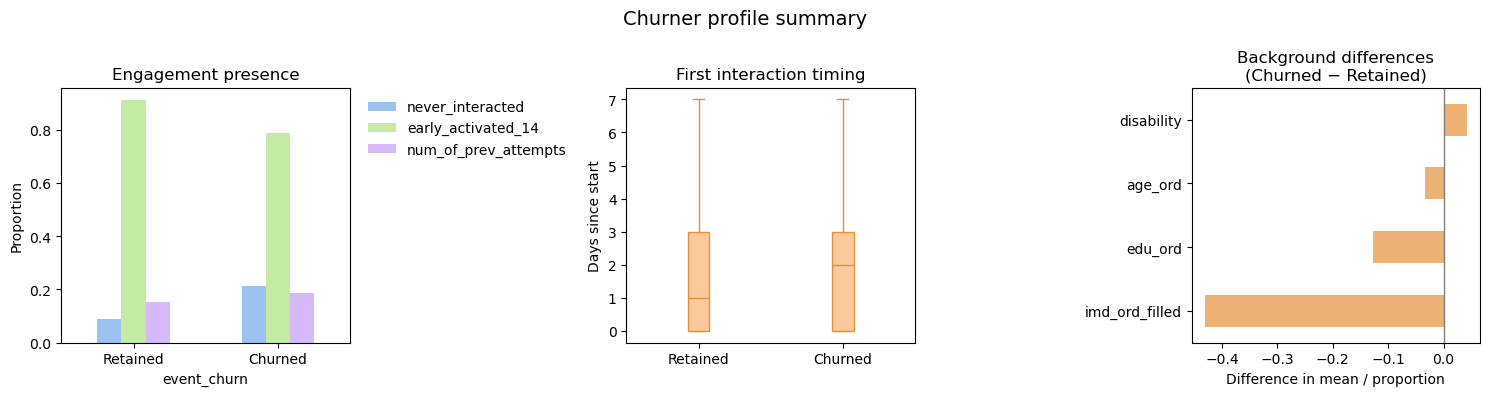

In [238]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Panel 1: engagement presence
(
    user_module_pre_surv
    .groupby('event_churn')[['never_interacted','early_activated_14','num_of_prev_attempts']]
    .mean()
    .plot(kind='bar', ax=axes[0],color=warm_colors['engagement'],alpha=0.7)
)
axes[0].set_title('Engagement presence')
axes[0].set_xticklabels(['Retained', 'Churned'], rotation=0)
axes[0].set_ylabel('Proportion')
axes[0].legend(
    title='',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    frameon=False
)


# Panel 2: timing & intensity 
# First interaction day
data_0 = user_module_pre_surv.loc[user_module_pre_surv['event_churn'] == 0, 'first_interaction_day'].dropna()
data_1 = user_module_pre_surv.loc[user_module_pre_surv['event_churn'] == 1, 'first_interaction_day'].dropna()

axes[1].boxplot([data_0, data_1], 
                labels=['Retained', 'Churned'],
                showfliers=False,
                patch_artist=True,
                boxprops=dict(facecolor='#F9CB9C', edgecolor='#E69138'),
                medianprops=dict(color='#E69138'),
                whiskerprops=dict(color='#E69138'),
                capprops=dict(color='#E69138'))
axes[1].set_title('First interaction timing')
axes[1].set_ylabel('Days since start')

# Panel 3: background 
bg_vars = ['age_ord', 'edu_ord', 'imd_ord_filled', 'disability']

bg_means = (
    user_module_pre_surv
    .groupby('event_churn')[bg_vars]
    .mean()
)

bg_diff = bg_means.loc[1] - bg_means.loc[0]  # Churned − Retained

bg_diff.sort_values().plot(
    kind='barh',
    ax=axes[2],
    color=warm_colors['background'],
    alpha=0.7
)

axes[2].axvline(0, color=warm_colors['zero_line'], linewidth=1)
axes[2].set_title('Background differences\n(Churned − Retained)')
axes[2].set_xlabel('Difference in mean / proportion')


plt.suptitle('Churner profile summary', fontsize=14)
plt.tight_layout()
plt.show()


Churner profile (churner vs retainer)

note: retainer = users who finally converted and user who retained witin the observation window but not converted (failed the course)
- high chance of never interecting with the course material
- lower chance of early activation within the first 2 weeks 
- higher previous attempts of the course 
- longer latency to first interact with the course material
- higher chance to have disability 
- being at younger ages 
- with lower education level 
- with lower index of deprivation/ from more deprived areas 

#### Converted user profile plot

C:\Users\08042\AppData\Local\Temp\ipykernel_54788\3205664939.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([data_0, data_1],


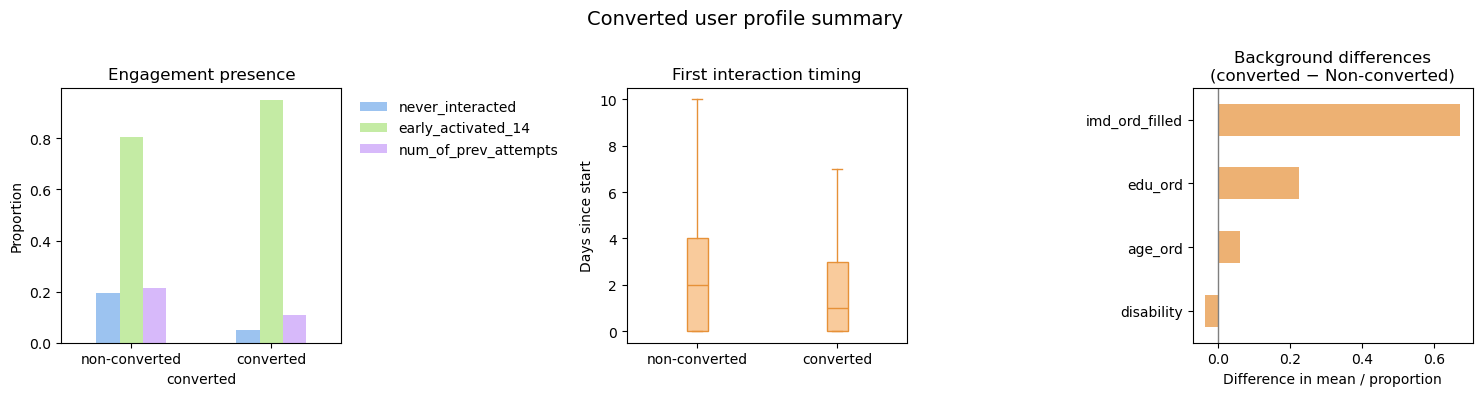

In [239]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Panel 1: engagement 
(
    user_module_pre_surv
    .groupby('converted')[['never_interacted','early_activated_14','num_of_prev_attempts']]
    .mean()
    .plot(kind='bar', ax=axes[0], color=warm_colors['engagement'], alpha=0.7)
)
axes[0].set_title('Engagement presence')
axes[0].set_xticklabels(['non-converted', 'converted'], rotation=0)
axes[0].set_ylabel('Proportion')
axes[0].legend(
    title='',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    frameon=False
)


# Panel 2: timing & intensity 
# First interaction day
data_0 = user_module_pre_surv.loc[user_module_pre_surv['converted'] == 0, 'first_interaction_day'].dropna()
data_1 = user_module_pre_surv.loc[user_module_pre_surv['converted'] == 1, 'first_interaction_day'].dropna()

axes[1].boxplot([data_0, data_1], 
                labels=['non-converted', 'converted'],
                showfliers=False,
                patch_artist=True,
                boxprops=dict(facecolor='#F9CB9C', edgecolor='#E69138'),
                medianprops=dict(color='#E69138'),
                whiskerprops=dict(color='#E69138'),
                capprops=dict(color='#E69138'))
axes[1].set_title('First interaction timing')
axes[1].set_ylabel('Days since start')

# Panel 3: background 
bg_vars = ['age_ord', 'edu_ord', 'imd_ord_filled', 'disability']

bg_means = (
    user_module_pre_surv
    .groupby('converted')[bg_vars]
    .mean()
)

bg_diff = bg_means.loc[1] - bg_means.loc[0]  # Converted − Non-converted
bg_diff.sort_values().plot(
    kind='barh',
    ax=axes[2],
    color=warm_colors['background'],
    alpha=0.7
)

axes[2].axvline(0, color=warm_colors['zero_line'], linewidth=1)
axes[2].set_title('Background differences\n(converted − Non-converted)')
axes[2].set_xlabel('Difference in mean / proportion')


plt.suptitle('Converted user profile summary', fontsize=14)
plt.tight_layout()
plt.show()


Converter profile (converter vs non-converter)
- lower chance of never interecting with the course material
- higher chance of early activation within the first 2 weeks 
- lower previous attempts of the course 
- shorter latency to first interact with the course material
- lower chance to have disability 
- being at older ages
- with higher education level 
- with higher index of deprivation/ from less deprived areas 

## Descriptive analysis - Chi-square test 

In [214]:
# presentation term x conversion 
from scipy.stats import chi2_contingency
ct = pd.crosstab(user_module_pre_surv['term_J'],user_module_pre_surv['converted'])
chi2,p,dof,expected = chi2_contingency(ct)
chi2, p

(93.74319906087207, 3.5923432990921143e-22)

In [215]:
# effect size - Cramer's V 
n = ct.values.sum()
cramer_v = np.sqrt(chi2/(n*(min(ct.shape)-1)))
cramer_v

0.05597716045787036

In [216]:
# early activation x conversion 
ct2 = pd.crosstab(user_module_pre_surv['early_activated_14'],user_module_pre_surv['converted'])
chi2,p,dof,expected = chi2_contingency(ct2)
chi2, p

(1476.7327036421723, 0.0)

In [217]:
n = ct2.values.sum()
cramer_v = np.sqrt(chi2/(n*(min(ct2.shape)-1)))
cramer_v

0.2221733306615448

In [218]:
# module x conversion 
ct3 = pd.crosstab(user_module_pre_surv['code_module'],user_module_pre_surv['converted'])
chi2,p,dof,expected = chi2_contingency(ct3)
chi2, p

(541.8937780886855, 7.892330544481413e-114)

In [219]:
n = ct3.values.sum()
cramer_v = np.sqrt(chi2/(n*(min(ct3.shape)-1)))
cramer_v

0.1345854346929736

Unadjusted chi-square tests showed a strong association between **early activation and module completion (conversion)** (χ² = 1476.7, p < .001, Cramér’s V = 0.22), whereas differences by presentation term were statistically significant but small in magnitude. 

## Retention Analysis 

### Retention curve (all users)

inf
          All users
timeline           
0.0        0.986195
1.0        0.985961
2.0        0.984156
3.0        0.982151
4.0        0.980713
...             ...
242.0      0.752820
261.0      0.752766
262.0      0.750925
268.0      0.750760
269.0      0.741675

[246 rows x 1 columns]


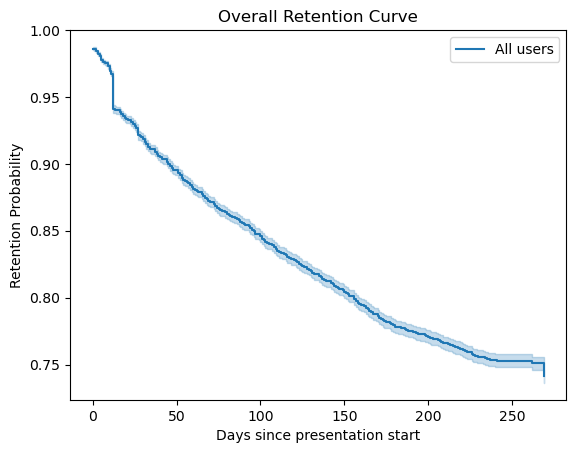

In [220]:
kmf=KaplanMeierFitter()
retention_kmf= kmf.fit(
    durations=user_module_pre_surv['time_to_churn'],
    event_observed=user_module_pre_surv['event_churn'],
    label='All users'
)
ax = kmf.plot_survival_function()
ax.set_title('Overall Retention Curve')
ax.set_ylabel('Retention Probability')
ax.set_xlabel('Days since presentation start')

print(retention_kmf.median_survival_time_)
print(retention_kmf.survival_function_)


### Retention curve by presentation type ('J' vs 'B')

Text(0.5, 0, 'Days since presentation start')

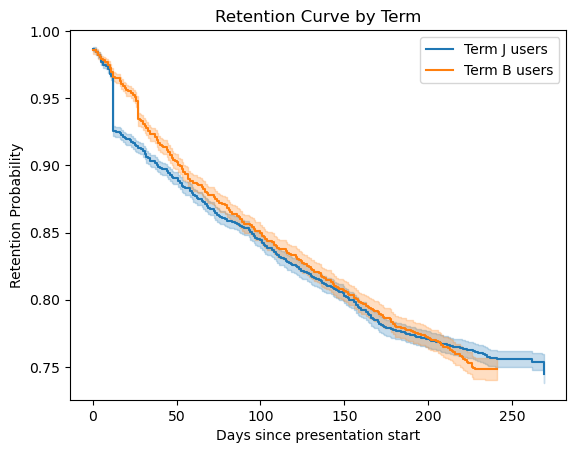

In [221]:
# retention curve by term
term_J = user_module_pre_surv[user_module_pre_surv['term_J']==1]
term_B = user_module_pre_surv[user_module_pre_surv['term_J']==0]
kmf_J=KaplanMeierFitter()
kmf_B=KaplanMeierFitter()
kmf_J.fit(
    durations=term_J['time_to_churn'],
    event_observed=term_J['event_churn'],
    label='Term J users'
)
kmf_B.fit(
    durations=term_B['time_to_churn'],
    event_observed=term_B['event_churn'],
    label='Term B users'
)
ax = kmf_J.plot_survival_function()
kmf_B.plot_survival_function(ax=ax)
ax.set_title('Retention Curve by Term')
ax.set_ylabel('Retention Probability')
ax.set_xlabel('Days since presentation start')


Retention drops sharply early in the module for both term users. The confidence intervals of the survival curves of Term J and Term B overlapped, indicating that the difference between the two was likely due to chance. 

### Retention curves by early activation in first 14 days ('active users' vs 'non-active users')

Text(0.5, 0, 'Days since presentation start')

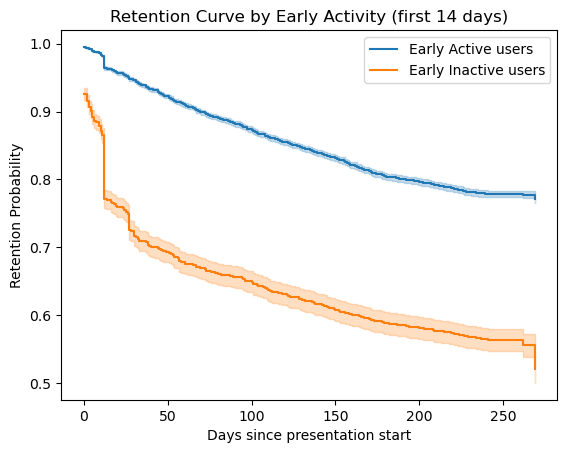

In [222]:
# retention by early activity
early_active = user_module_pre_surv[user_module_pre_surv['early_activated_14']==1]
early_inactive = user_module_pre_surv[user_module_pre_surv['early_activated_14']==0]
kmf_active=KaplanMeierFitter()
kmf_inactive=KaplanMeierFitter()
kmf_active.fit(
    durations=early_active['time_to_churn'],
    event_observed=early_active['event_churn'],
    label='Early Active users'
)
kmf_inactive.fit(
    durations=early_inactive['time_to_churn'],
    event_observed=early_inactive['event_churn'],
    label='Early Inactive users'
)
ax = kmf_active.plot_survival_function()
kmf_inactive.plot_survival_function(ax=ax)
ax.set_title('Retention Curve by Early Activity (first 14 days)')
ax.set_ylabel('Retention Probability')
ax.set_xlabel('Days since presentation start')

Retention drops sharply early (first 50 days) for early inactive users, and early activation within the first 14 days is associated with substantially longer persistence.

### Log-rank analysis of survival between groups

In [223]:
# log-rank test between presentation types 
lrt_presentation = logrank_test(
    term_J['time_to_churn'],
    term_B['time_to_churn'],
    event_observed_A=term_J['event_churn'],
    event_observed_B=term_B['event_churn']
)
print(lrt_presentation.summary)

   test_statistic         p  -log2(p)
0        0.943819  0.331298  1.593801


In [224]:
# log-rank test between early active vs inactive users
lrt_early_activity = logrank_test(
    early_active['time_to_churn'],
    early_inactive['time_to_churn'],
    event_observed_A=early_active['event_churn'],
    event_observed_B=early_inactive['event_churn']
)
print(lrt_early_activity.summary)

   test_statistic              p    -log2(p)
0     1191.763492  3.761207e-261  865.112037


Log-rank tests confirm that survival curves statistically differ for early activation (p<.05) but not for presentation type (p=.33), but they do not quantify effect size or control for covariates.

Therefore, regression analysis are needed to further quantify the effect of presentation type and early activation on survival.

## Survival analysis regession model

In [225]:
model_cols = ['time_to_churn','event_churn','term_J','early_activated_14','edu_ord','age_ord','num_of_prev_attempts','studied_credits','disability']
df = user_module_pre_surv[model_cols].copy()
df = df.dropna().reset_index(drop=True)

### Checking the Cox Proportional Hazards Assumptions

In [226]:
# if satisfy cox proportional hazard assumption, fit Cox regression model
from lifelines import CoxPHFitter
cph= CoxPHFitter()
cph.fit(df,
        duration_col='time_to_churn', 
        event_col='event_churn',
        formula='term_J + early_activated_14 + edu_ord + age_ord')
cph.print_summary()
cph.check_assumptions(df, p_value_threshold=0.05, show_plots=False)

<lifelines.CoxPHFitter: fitted with 29714 total observations, 22275 right-censored observations>
             duration col = 'time_to_churn'
                event col = 'event_churn'
      baseline estimation = breslow
   number of observations = 29714
number of events observed = 7439
   partial log-likelihood = -74938.07
         time fit was run = 2025-12-17 17:32:54 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
term_J             -0.02      0.98      0.02           -0.07            0.02                0.93                1.02
early_activated_14 -0.92      0.40      0.03           -0.98           -0.87                0.38                0.42
edu_ord            -0.18      0.84      0.02           -0.21           -0.14                0.81                0.87
age_ord            -0.14      0.87      0.03           -0.19           -0.08                0.83                0.92

                    cmp to      z      p  -log2(p)
covariate                                         
term_J                0.00  -0.96   0.34      1.56
early_activated_14    0.00 -32.58 <0.005    770.91
edu_ord               0.00 -10.82 <0.005     88.29
age_ord               0.00  -5.16 <0.005     21.94
---
Concordance = 0.60
Partial AIC = 149884.14
log-likelihood ratio test = 1086.55 on 4 df
-log2(p) of ll-ratio test = 774.69

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 29714 total observations, 22275 right-censored observations>
         test_name = proportional_hazard_test

---
                         test_statistic      p  -log2(p)
age_ord            km             15.55 <0.005     13.60
                   rank           17.07 <0.005     14.76
early_activated_14 km            481.48 <0.005    352.10
                   rank          517.64 <0.005    378.24
edu_ord            km             15.98 <0.005     13.93
                   rank           17.37 <0.005     14.99
term_J             km             52.81 <0.005     41.30
                   rank           64.86 <0.005     50.15



1. Variable 'term_J' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['term_J', ...]` in the call
in `.fit`. See documentation in link [E] below.

2. Variable 'early_activated_14' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['early_activated_14', ...]`
in the call in `.fit`. See documentation in link [E] below.

3. Variable 'edu_ord' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 5), you can include `strata=['edu_ord', ...]` in the call
in `.fit`. See documentation in link [E] below.

4. Variable 'age_ord' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['age_ord', ...]` in the call
in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Prop

[]

In [227]:
# test Cox PH model with term J as strata
cph = CoxPHFitter()
cph.fit(
    df,
    duration_col='time_to_churn',
    event_col='event_churn',
    strata=['term_J'],
    formula='early_activated_14 + edu_ord + age_ord'
)
cph.print_summary()
cph.check_assumptions(df, p_value_threshold=0.05, show_plots=False)



<lifelines.CoxPHFitter: fitted with 29714 total observations, 22275 right-censored observations>
             duration col = 'time_to_churn'
                event col = 'event_churn'
                   strata = term_J
      baseline estimation = breslow
   number of observations = 29714
number of events observed = 7439
   partial log-likelihood = -70030.92
         time fit was run = 2025-12-17 17:32:55 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
early_activated_14 -0.92      0.40      0.03           -0.98           -0.87                0.38                0.42
edu_ord            -0.18      0.84      0.02           -0.21           -0.14                0.81                0.87
age_ord            -0.13      0.87      0.03           -0.19           -0.08                0.83                0.92

                    cmp to      z      p  -log2(p)
covariate                                         
early_activated_14    0.00 -32.53 <0.005    768.67
edu_ord               0.00 -10.82 <0.005     88.30
age_ord               0.00  -5.14 <0.005     21.80
---
Concordance = 0.60
Partial AIC = 140067.84
log-likelihood ratio test = 1083.38 on 3 df
-log2(p) of ll-ratio test = 776.78

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 29714 total observations, 22275 right-censored observations>
         test_name = proportional_hazard_test

---
                         test_statistic      p  -log2(p)
age_ord            km             15.34 <0.005     13.45
                   rank            0.16   0.69      0.54
early_activated_14 km            480.22 <0.005    351.19
                   rank          107.51 <0.005     81.26
edu_ord            km             15.94 <0.005     13.90
                   rank            4.77   0.03      5.11



1. Variable 'early_activated_14' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['early_activated_14', ...]`
in the call in `.fit`. See documentation in link [E] below.

2. Variable 'edu_ord' failed the non-proportional test: p-value is 0.0001.

   Advice: with so few unique values (only 5), you can include `strata=['edu_ord', ...]` in the call
in `.fit`. See documentation in link [E] below.

3. Variable 'age_ord' failed the non-proportional test: p-value is 0.0001.

   Advice: with so few unique values (only 2), you can include `strata=['age_ord', ...]` in the call
in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/ju

[]

### Weibull Accelerated Failure Time (AFT) Model 

Given time-varying effects and decreasing hazard over time, I selected a Weibull AFT model as the primary analysis, which directly models time-to-churn without assuming proportional hazards.

#### Weibull model and plot

In [228]:
# run Weibull AFT model for robustness check
from lifelines import WeibullAFTFitter
aft = WeibullAFTFitter()

# check time_to_churn values 
df['time_to_churn'].sort_values(ascending=True)
# add small epsilon to time_to_churn to avoid zero durations (wb cannot handle zero durations)
epsilon = 0.5
df['time_to_churn_wb'] = df['time_to_churn'].clip(lower=epsilon)

aft.fit(df, 
        duration_col='time_to_churn_wb', 
        event_col='event_churn',
        formula='term_J + early_activated_14 + edu_ord + age_ord')
aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 29714 total observations, 22275 right-censored observations>
             duration col = 'time_to_churn_wb'
                event col = 'event_churn'
   number of observations = 29714
number of events observed = 7439
           log-likelihood = -55849.42
         time fit was run = 2025-12-17 17:32:56 UTC

---
                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                           
lambda_ Intercept           5.68    292.04      0.06            5.55            5.80              257.95              330.64
        term_J              0.09      1.10      0.04            0.02            0.17                1.02                1.19
        early_activated_14  1.51      4.54      0.05            1.42            1.61                4.12                5.00
        edu_ord             0.29      1.33      0.03            0.23            0.34                1.26                1.40
        age_ord             0.22      1.25      0.04            0.14            0.31                1.15                1.36
rho_    Intercept          -0.49      0.61      0.01           -0.52           -0.47                0.60                0.62

                            cmp to      z      p  -log2(p)
param   covariate                                         
lambda_ Intercept             0.00  89.64 <0.005       inf
        term_J                0.00   2.41   0.02      5.96
        early_activated_14    0.00  30.97 <0.005    697.28
        edu_ord               0.00  10.75 <0.005     87.09
        age_ord               0.00   5.17 <0.005     22.03
rho_    Intercept             0.00 -44.58 <0.005       inf
---
Concordance = 0.60
AIC = 111710.85
log-likelihood ratio test = 1090.37 on 4 df
-log2(p) of ll-ratio test = 777.45

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

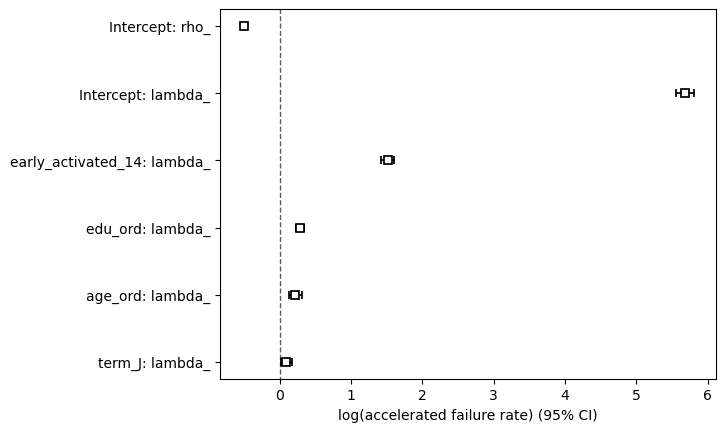

In [229]:
aft.plot()

#### Extended Weibull model and plot

In [230]:
# extended model with more covariates 
aft.fit(df, 
        duration_col='time_to_churn_wb', 
        event_col='event_churn',
        formula='term_J + early_activated_14 + edu_ord + age_ord + num_of_prev_attempts + studied_credits + disability')
aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 29714 total observations, 22275 right-censored observations>
             duration col = 'time_to_churn_wb'
                event col = 'event_churn'
   number of observations = 29714
number of events observed = 7439
           log-likelihood = -55500.93
         time fit was run = 2025-12-17 17:32:57 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                             
lambda_ Intercept             6.52    679.47      0.07            6.38            6.66              589.62              783.00
        term_J                0.04      1.04      0.04           -0.04            0.11                0.96                1.12
        early_activated_14    1.57      4.82      0.05            1.48            1.67                4.38                5.30
        edu_ord               0.30      1.34      0.03            0.24            0.35                1.28                1.42
        age_ord               0.15      1.16      0.04            0.07            0.23                1.07                1.26
        num_of_prev_attempts  0.13      1.14      0.04            0.06            0.21                1.06                1.23
        studied_credits      -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
        disability           -0.44      0.65      0.06           -0.55           -0.33                0.58                0.72
rho_    Intercept            -0.48      0.62      0.01           -0.51           -0.46                0.60                0.63

                              cmp to      z      p  -log2(p)
param   covariate                                           
lambda_ Intercept               0.00  90.12 <0.005       inf
        term_J                  0.00   0.94   0.35      1.53
        early_activated_14      0.00  32.17 <0.005    751.95
        edu_ord                 0.00  11.06 <0.005     92.02
        age_ord                 0.00   3.49 <0.005     10.99
        num_of_prev_attempts    0.00   3.43 <0.005     10.69
        studied_credits         0.00 -26.91 <0.005    527.62
        disability              0.00  -7.67 <0.005     45.73
rho_    Intercept               0.00 -43.96 <0.005       inf
---
Concordance = 0.60
AIC = 111019.86
log-likelihood ratio test = 1787.36 on 7 df
-log2(p) of ll-ratio test = inf

AIC reduced indicates better model fit of the extended AFT model. 
- exp(coef) = 1.04, p=0.35, term effects are time-varying and structural, not a stable average shift.
- exp(coef) = 4.82, students who activate within the first 14 days stay enrolled about 4.8 times longer than those who do not, holding other factors constant.
- exp(coef) = 1.34, each higher education level is associated with ~34% longer retention time.
- exp(coef) = 1.16, older students remain enrolled about 16% longer than younger students.
- exp(coef) = 1.14, each previous attempt is associated with ~14% longer retention time.
- exp(coef) = 0.99, higher total credits slightly reduces retention time.
- exp(coef) = 0.65, declared disability is associated with 35% shorter time-to-churn. Likely reflects unmet support needs / sctructural barriers. 
- rho_ = 0.62, Churn risk is highest early in the module and decreases as students progress.

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

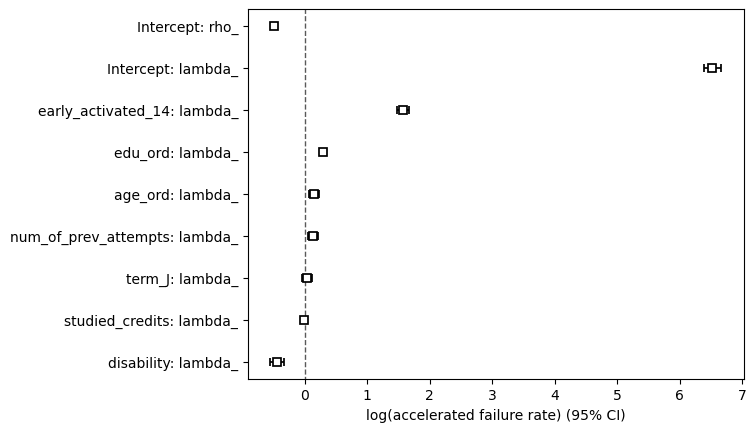

In [231]:
aft.plot()

<Axes: >

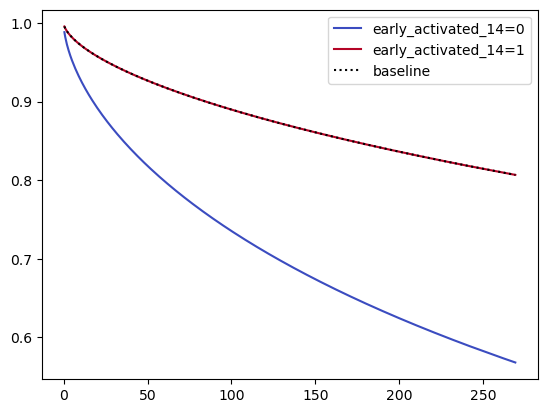

In [232]:
baseline = df.median()

df_active = baseline.copy()
df_active['early_activated_14'] = 1

df_inactive = baseline.copy()
df_inactive['early_activated_14'] = 0

aft.plot_partial_effects_on_outcome(
    covariates='early_activated_14',
    values=[0, 1],
    cmap='coolwarm'
) 
# df['early_activated_14'].median() =1 

## Conversion analysis 
--- 
- Outcome: course completion ('yes' = 'pass' and 'distinction'/'no' = 'fail' and 'withdrawal') / conversion 
- Method: logistic regression 
- Question: Among retained users, who is more likely to complete the course?

In [233]:
user_module_pre_surv

,id_student,code_module,code_presentation,presentation_year,term_J,converted,churned,time_to_churn,event_churn,date_registration,...,num_of_prev_attempts,studied_credits,prestart_clicks,prestart_active,early_clicks_14,early_active_days_14,early_activated_14,first_interaction_day_0plus,never_interacted,first_interaction_day
0,11391,AAA,2013J,2013,1,1,0,268.0,0,-159.0,...,0,240,98.0,1.0,203.0,5.0,1.0,0.0,0,0.0
1,28400,AAA,2013J,2013,1,1,0,268.0,0,-53.0,...,0,60,215.0,1.0,241.0,7.0,1.0,0.0,0,0.0
2,30268,AAA,2013J,2013,1,0,1,12.0,1,-92.0,...,0,60,102.0,1.0,179.0,6.0,1.0,4.0,0,4.0
3,31604,AAA,2013J,2013,1,1,0,268.0,0,-52.0,...,0,60,169.0,1.0,176.0,7.0,1.0,1.0,0,1.0
4,32885,AAA,2013J,2013,1,1,0,268.0,0,-176.0,...,0,60,295.0,1.0,177.0,9.0,1.0,1.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29912,2640965,GGG,2014J,2014,1,0,0,269.0,0,-4.0,...,0,30,2.0,1.0,17.0,2.0,1.0,0.0,0,0.0
29913,2645731,GGG,2014J,2014,1,1,0,269.0,0,-23.0,...,0,30,0.0,0.0,0.0,0.0,0.0,inf,1,NaN
29914,2648187,GGG,2014J,2014,1,1,0,269.0,0,-129.0,...,0,30,15.0,1.0,9.0,1.0,1.0,5.0,0,5.0
29915,2679821,GGG,2014J,2014,1,0,1,101.0,1,-49.0,...,0,30,65.0,1.0,4.0,1.0,1.0,3.0,0,3.0


In [234]:
conversion_logit = smf.logit('converted ~ term_J + early_activated_14 + early_clicks_14 + Gender + age_ord + edu_ord + num_of_prev_attempts + studied_credits + disability',data=user_module_pre_surv).fit()
conversion_logit.summary()
or_df=np.exp(conversion_logit.params)
ci = np.exp(conversion_logit.conf_int())
or_table = pd.concat([or_df,ci],axis=1)
or_table.columns = ['OR','CI_lower','CI_upper']
or_table 

Optimization terminated successfully.
         Current function value: 0.623211
         Iterations 6


,OR,CI_lower,CI_upper
Intercept,0.229641,0.204457,0.257927
term_J,1.294626,1.231114,1.361413
early_activated_14,3.224917,2.950400,3.524976
early_clicks_14,1.003012,1.002815,1.003209
Gender,0.685178,0.651732,0.720339
age_ord,1.105492,1.046635,1.167658
edu_ord,1.471682,1.422943,1.522091
num_of_prev_attempts,0.741684,0.701306,0.784386
studied_credits,0.994207,0.993551,0.994864
disability,0.727743,0.669479,0.791078


variables that increase retention time (i.e. early activation, education) also increase the odds of conversion (pass or achieving distinction). 

In [235]:
# check model performance (pseudo R^2)
print(conversion_logit.prsquared)
conversion_logit.summary()

0.1004372229693411


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                29714
Model:                          Logit   Df Residuals:                    29704
Method:                           MLE   Df Model:                            9
Date:                Wed, 17 Dec 2025   Pseudo R-squ.:                  0.1004
Time:                        17:32:58   Log-Likelihood:                -18518.
converged:                       True   LL-Null:                       -20586.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.4712      0.059    -24.824      0.000      -1.587      -1.355
term_J                   0.2582      0.026     10.061      0.000       0.208       0.309
early_activated_14       1.1709      0.045     25.795      0.000       1.082       1.260
early_clicks_14          0.0030      0.000     29.992      0.000       0.003       0.003
Gender                  -0.3781      0.026    -14.807      0.000      -0.428      -0.328
age_ord                  0.1003      0.028      3.593      0.000       0.046       0.155
edu_ord                  0.3864      0.017     22.487      0.000       0.353       0.420
num_of_prev_attempts    -0.2988      0.029    -10.463      0.000      -0.355      -0.243
studied_credits         -0.0058      0.000    -17.241      0.000      -0.006      -0.005
disability              -0.3178      0.043     -7.464      0.000      -0.401      -0.234
========================================================================================
"""

McFadden pseudo-R²= 0.1, meaning the model improved the liklihood over the null model (interpect only model) and the model has a good fit. 

In [236]:
# check ROC AUC
model_cols = [
    'converted',
    'term_J',
    'early_activated_14',
    'early_clicks_14',
    'Gender',
    'age_ord',
    'edu_ord',
    'num_of_prev_attempts',
    'studied_credits',
    'disability',
]

df_logit = user_module_pre_surv[model_cols].dropna().copy()


from sklearn.metrics import roc_auc_score
y = df_logit['converted']
y_pred = conversion_logit.predict(df_logit)

print('NaNs in y:', y.isna().sum())
print('NaNs in pred:', pd.isna(y_pred).sum())
roc_auc_score(y, y_pred)

NaNs in y: 0
NaNs in pred: 0


0.7126159196045323

ROC–AUC summarizes the trade-off between true and false positive rates across all thresholds, measuring how well the model ranks converted users above non-converted users. ROC-AUC of 0.71 indicates that the model performed discrimination reasonably well.  

In [237]:
# module fixed effects model for robustness check 
conversion_logit = smf.logit('converted ~ code_module + term_J + early_activated_14 + early_clicks_14 + Gender + age_ord + edu_ord + num_of_prev_attempts + studied_credits + disability',data=user_module_pre_surv).fit()
conversion_logit.summary()
or_df=np.exp(conversion_logit.params)
ci = np.exp(conversion_logit.conf_int())
or_table = pd.concat([or_df,ci],axis=1)
or_table.columns = ['OR','CI_lower','CI_upper']
or_table 
conversion_logit.summary()

Optimization terminated successfully.
         Current function value: 0.610124
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                29714
Model:                          Logit   Df Residuals:                    29698
Method:                           MLE   Df Model:                           15
Date:                Wed, 17 Dec 2025   Pseudo R-squ.:                  0.1193
Time:                        17:32:59   Log-Likelihood:                -18129.
converged:                       True   LL-Null:                       -20586.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.4862      0.117    -12.690      0.000      -1.716      -1.257
code_module[T.BBB]      -0.1757      0.097     -1.817      0.069      -0.365       0.014
code_module[T.CCC]      -1.1437      0.098    -11.641      0.000      -1.336      -0.951
code_module[T.DDD]      -0.7740      0.096     -8.065      0.000      -0.962      -0.586
code_module[T.EEE]      -0.4013      0.101     -3.967      0.000      -0.600      -0.203
code_module[T.FFF]      -0.8549      0.096     -8.911      0.000      -1.043      -0.667
code_module[T.GGG]       0.2826      0.105      2.686      0.007       0.076       0.489
term_J                   0.2126      0.026      8.084      0.000       0.161       0.264
early_activated_14       1.2693      0.047     27.198      0.000       1.178       1.361
early_clicks_14          0.0035      0.000     32.127      0.000       0.003       0.004
Gender                  -0.0245      0.032     -0.770      0.441      -0.087       0.038
age_ord                  0.0237      0.029      0.830      0.406      -0.032       0.080
edu_ord                  0.4600      0.018     25.837      0.000       0.425       0.495
num_of_prev_attempts    -0.2804      0.029     -9.687      0.000      -0.337      -0.224
studied_credits         -0.0038      0.000    -10.568      0.000      -0.005      -0.003
disability              -0.3252      0.043     -7.518      0.000      -0.410      -0.240
========================================================================================
"""

## **Conclusion** 
- Early activation within the first 14 days are crucial for retaining users, which supported by regression analysis adjusting for demographic and course-related covariates. 
- Variables that increase retention time (i.e. early activation, education) also increase the odds of conversion (pass or achieving distinction). 

## **Recommendations** 
- **Improve early acitvation/engagement with the course material within the first 14 days**
  - Encourage early activation through social media, email, and other channels.
  - Introduce short onboarding videos, interactive quizzes, and light-weight gamified activities to lower the barrier to initial engagement and make the learning experience more engaging.
  - Add lightweight gamification
    - Daily missions, beginner quests, achievement streaks, and progress bars to create early momentum.
- **Provide additional resources/support to at risk users**
  - Making the course content more accessible to people with different academic backgrounds and abilities.
    - simplifying content structure, providing alternative formats (e.g. subtitles, color-blind modes, text-to-speech, transcripts), and clearly signposting support resources.
    - Customisable UI and 'guide-mode' for the system. 
  - Sending pre-course surveys to users to collect information about users' background and interests. 
  - User profiling and segmentation
    - Use early-course engagement to infer player needs and preferences.
    - Personalise tutorials, challenges, or rewards based on play style and progression speed.
- **Feedback and community building**
  - Open feedback channels to collect feedback from users. 
  - Building user communities and encourage user engagement and peer learning/teaching. 
- **Monitor the retention and dropout rates of users and adjust the course content accordingly** 
  - Cohort-based retention analysis
    - Track new user cohorts over time to identify when and where churn spikes.
  - Live experimentation
    - Conduct A/B testing with different early-stage incentives and messaging strategies.
  - Content iteration
    - Adjust early content pacing, progression speed, and reward frequency based on observed behaviour.
    - Rotate or refresh early-course content to keep the experience feeling dynamic.